# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2018


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2018-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    123,653    4,874   2,552   1,850   1,852
  1           9thStreet    117,786    4,332   3,156   2,496   2,100
  2          14thStreet    222,295    8,611   4,704   3,536   4,251
  3          23rdStreet    230,031    9,670   2,995   2,133   3,220
  4          33rdStreet    820,412   32,966  14,134  10,198  15,402
  5     UPTOWN SUBTOTAL  1,514,177   60,453  27,541  20,213  26,825
  6                 WTC  1,399,721   59,078  17,211  13,178  18,762
  7   NEW YORK SUBTOTAL  2,913,898  119,531  44,752  33,391  45,587,
                       0          1        2        3       4       5
  0               Newark    706,467   29,577    9,745   6,605   9,980
  1             Harrison    193,969    8,116    2,794   1,794   2,588
  2       Journal Square    627,460   24,813   12,426   8,618  11,106
  3         Grove Street    495,241   19,837    9,586   6,431   7,297
  4       Exchange Place    398,15

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"123,653","4,874","2,552","1,850","1,852",2018-01-01
1,9thStreet,"117,786","4,332","3,156","2,496","2,100",2018-01-01
2,14thStreet,"222,295","8,611","4,704","3,536","4,251",2018-01-01
3,23rdStreet,"230,031","9,670","2,995","2,133","3,220",2018-01-01
4,33rdStreet,"820,412","32,966","14,134","10,198","15,402",2018-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"397,272","16,881","6,456","4,632","4,209",2018-12-01
5,Pavonia/ Newport,"445,572","18,153","9,139","6,296","5,346",2018-12-01
6,Hoboken,"628,508","26,421","12,124","7,232","3,307",2018-12-01
7,NEW JERSEY SUBTOTAL,"3,482,374","142,346","71,473","48,207","37,049",2018-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,123653,4874,2552,1850,1852,2018-01-01
1,9thStreet,117786,4332,3156,2496,2100,2018-01-01
2,14thStreet,222295,8611,4704,3536,4251,2018-01-01
3,23rdStreet,230031,9670,2995,2133,3220,2018-01-01
4,33rdStreet,820412,32966,14134,10198,15402,2018-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,397272,16881,6456,4632,4209,2018-12-01
5,Pavonia/ Newport,445572,18153,9139,6296,5346,2018-12-01
6,Hoboken,628508,26421,12124,7232,3307,2018-12-01
7,NEW JERSEY SUBTOTAL,3482374,142346,71473,48207,37049,2018-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3989,102346,10206,7398,3703,2018-01-01
1,9thStreet,3800,90976,12626,9984,4200,2018-01-01
2,14thStreet,7171,180835,18815,14143,8502,2018-01-01
3,23rdStreet,7420,203079,11980,8532,6440,2018-01-01
4,33rdStreet,26465,692280,56538,40791,30803,2018-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,12815,337626,32278,23159,4209,2018-12-01
5,Pavonia/ Newport,14373,363053,45695,31478,5346,2018-12-01
6,Hoboken,20274,528422,60621,36158,3307,2018-12-01
7,NEW JERSEY SUBTOTAL,112335,2846934,357365,241026,37049,2018-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2018-01-01 Christopher Street        3989         4874     2552     1850   
           9thStreet                 3800         4332     3156     2496   
           14thStreet                7171         8611     4704     3536   
           23rdStreet                7420         9670     2995     2133   
           33rdStreet               26465        32966    14134    10198   
...                                   ...          ...      ...      ...   
2018-12-01 Exchange Place           12815        16881     6456     4632   
           Pavonia/ Newport         14373        18153     9139     6296   
           Hoboken                  20274        26421    12124     7232   
           NEW JERSEY SUBTOTAL     112335       142346    71473    48207   
           MONTHLY TOTAL           204884       258220   131000    92491   

                                avg holiday    total  total weekday  \
month      station                                                    
2018-01-01 Christopher Street          1852   123653         102346   
           9thStreet                   2100   117786          90976   
           14thStreet                  4251   222295         180835   
           23rdStreet                  3220   230031         203079   
           33rdStreet                 15402   820412         692280   
...                                     ...      ...            ...   
2018-12-01 Exchange Place              4209   397272         337626   
           Pavonia/ Newport            5346   445572         363053   
           Hoboken                     3307   628508         528422   
           NEW JERSEY SUBTOTAL        37049  3482374        2846934   
           MONTHLY TOTAL              69559  6351416        5164402   

                                total sat  total sun  total holiday  
month      station                                                   
2018-01-01 Christopher Street       10206       7398           3703  
           9thStreet                12626       9984           4200  
           14thStreet               18815      14143           8502  
           23rdStreet               11980       8532           6440  
           33rdStreet               56538      40791          30803  
...                                   ...        ...            ...  
2018-12-01 Exchange Place           32278      23159           4209  
           Pavonia/ Newport         45695      31478           5346  
           Hoboken                  60621      36158           3307  
           NEW JERSEY SUBTOTAL     357365     241026          37049  
           MONTHLY TOTAL           655001     462454          69559  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

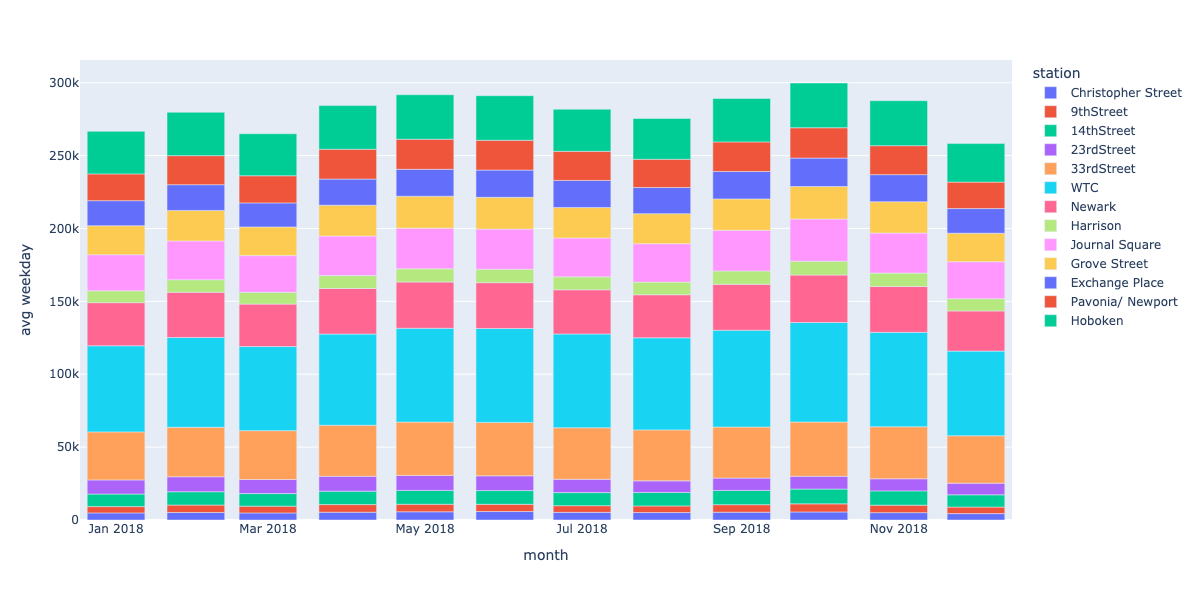

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))